In [1]:
import pandas as pd
import numpy as np
import re
import pickle

In [2]:
subset_punk_df = pd.read_csv('../data/subset_punk_bands.csv')
subset_punk_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [7]:
subset_punk_df

,ARTIST_NAME,ARTIST_URL,SONG_NAME,SONG_URL,LYRICS
0,all time low,https://www.azlyrics.com/a/alltimelow.html,i can't do the one-two step,https://www.azlyrics.com/lyrics/alltimelow/ica...,front page of the magazine said don't believe ...
1,all time low,https://www.azlyrics.com/a/alltimelow.html,the girl's a straight-up hustler,https://www.azlyrics.com/lyrics/alltimelow/the...,lipstick has a way of leaving more than just a...
2,all time low,https://www.azlyrics.com/a/alltimelow.html,"sticks, stones, and techno",https://www.azlyrics.com/lyrics/alltimelow/sti...,you spin your words like a record in motion st...
3,all time low,https://www.azlyrics.com/a/alltimelow.html,coffee shop soundtrack,https://www.azlyrics.com/lyrics/alltimelow/cof...,should i write myself out of the history books...
4,all time low,https://www.azlyrics.com/a/alltimelow.html,break out! break out!,https://www.azlyrics.com/lyrics/alltimelow/bre...,luck loves me not tonight i'm running out this...
...,...,...,...,...,...
544,yellowcard,https://www.azlyrics.com/y/yellowcard.html,what appears,https://www.azlyrics.com/lyrics/yellowcard/wha...,slow steady hands waving their last goodbye th...
545,yellowcard,https://www.azlyrics.com/y/yellowcard.html,got yours,https://www.azlyrics.com/lyrics/yellowcard/got...,stacking bricks on broken ground building towe...
546,yellowcard,https://www.azlyrics.com/y/yellowcard.html,a place we set afire,https://www.azlyrics.com/lyrics/yellowcard/apl...,you feel it you boxed it by the youth you left...
547,yellowcard,https://www.azlyrics.com/y/yellowcard.html,leave a light on,https://www.azlyrics.com/lyrics/yellowcard/lea...,so where are you and how's it been how's the w...


## Creating a model

### Setting up the data

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Input, Embedding, Dropout, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model

In [4]:
# "randomly" choose one band to test if model works
yellowcard = subset_punk_df.LYRICS[subset_punk_df.ARTIST_NAME == 'yellowcard']


# for full model
# take out spaces in the artist names
new_artist_names = [re.sub(r'\W', '', string = subset_punk_df.ARTIST_NAME[w]) for w in range(len(subset_punk_df.ARTIST_NAME))]

tokenizer_artist = Tokenizer()
tokenizer_artist.fit_on_texts(new_artist_names)
artist_seq = tokenizer_artist.texts_to_sequences(new_artist_names)

tokenizer_lyrics = Tokenizer()
tokenizer_lyrics.fit_on_texts([str(lyr) for lyr in subset_punk_df.LYRICS])

token_seq = tokenizer_lyrics.texts_to_sequences([str(lyr) for lyr in subset_punk_df.LYRICS])


n_gram_seq = []
artists = []
# for every line in tokenized sequences
for line, band in zip(token_seq, artist_seq):
    # used to append the token_seq starting from 0th element to 1st element
    for length in range(2, len(line)):
        n_gram_seq.append(line[:length])
        artists.append(band)
        
artists = np.array(artists)

In [5]:
# create padded sequences
n_gram_seq_padded = pad_sequences(n_gram_seq, maxlen = 11)

In [6]:
n_gram_seq_padded[:11]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,  700, 1615],
       [   0,    0,    0,    0,    0,    0,    0,    0,  700, 1615,   17],
       [   0,    0,    0,    0,    0,    0,    0,  700, 1615,   17,    3],
       [   0,    0,    0,    0,    0,    0,  700, 1615,   17,    3, 1452],
       [   0,    0,    0,    0,    0,  700, 1615,   17,    3, 1452,   90],
       [   0,    0,    0,    0,  700, 1615,   17,    3, 1452,   90,   20],
       [   0,    0,    0,  700, 1615,   17,    3, 1452,   90,   20,  155],
       [   0,    0,  700, 1615,   17,    3, 1452,   90,   20,  155,    7],
       [   0,  700, 1615,   17,    3, 1452,   90,   20,  155,    7,  425],
       [ 700, 1615,   17,    3, 1452,   90,   20,  155,    7,  425,    2],
       [1615,   17,    3, 1452,   90,   20,  155,    7,  425,    2,  407]],
      dtype=int32)

In [8]:
# create labels by using One Hot Encoding 
labels = to_categorical(n_gram_seq_padded[:,-1:])
X = n_gram_seq_padded[:,:-1]

# training size (0.8 of the model)
train_size = round(n_gram_seq_padded.shape[0]*0.8)
# get randomly chosen indices of artists for training
ids = np.random.choice(range(len(artists)), train_size, replace = False)

# create test and train
y_train = labels[ids]
y_test = np.delete(labels, ids, axis = 0)

lyrics_train = X[ids]
lyrics_test = np.delete(X, ids, axis = 0)

artist_train = artists[ids]
artist_test = np.delete(artists, ids, axis = 0)

# find largest vocab size in padded sequence; this is input size
vocab_size = max([w for sentence in n_gram_seq_padded for w in sentence]) + 1
artist_size = max([len(art) for art in artists]) + 1

In [9]:
# define the two inputs
inputA = Input(shape = (10, ))
inputB = Input(shape = (1,))

# first branch for first input
lyrics = Embedding(input_dim = vocab_size, output_dim = 64, input_length = 10)(inputA)
lyrics = Bidirectional(LSTM(128, return_sequences = True))(lyrics)
lyrics = Dropout(0.2)(lyrics)
lyrics = LSTM(64)(lyrics)
lyrics = Dense(round(vocab_size/2), activation = 'relu')(lyrics)
lyrics = Dense(vocab_size, activation = 'softmax')(lyrics)
lyrics = Model(inputs = inputA, outputs = lyrics)

# second branch for second input
artist = Dense(64, activation = 'relu')(inputB)
artist = Dense(10, activation = 'relu')(artist)
artist = Dense(vocab_size, activation = 'relu')(artist)
artist = Model(inputs = inputB, outputs = artist)


# combine output of branches
combined = concatenate([lyrics.output, artist.output])


z = Dense(2, activation = 'relu')(combined)
z = Dense(vocab_size, activation = 'softmax')(z)
model = keras.Model(inputs = [lyrics.input, artist.input], outputs = z)

#compile model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [10]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 64)       382656      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 256)      197632      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10, 256)      0           bidirectional[0][0]              
____________________________________________________________________________________________

In [11]:
# history = model.fit([lyrics_train, artist_train], y_train, epochs = 8, validation_data = ([lyrics_test, artist_test], y_test))

Epoch 1/8
3356/3356 [==============================] - 810s 240ms/step - loss: 6.5144 - accuracy: 0.0376 - val_loss: 6.2327 - val_accuracy: 0.0381
Epoch 2/8
3356/3356 [==============================] - 840s 250ms/step - loss: 6.1496 - accuracy: 0.0374 - val_loss: 6.2455 - val_accuracy: 0.0381
Epoch 3/8
3356/3356 [==============================] - 567s 169ms/step - loss: 6.1448 - accuracy: 0.0383 - val_loss: 6.2692 - val_accuracy: 0.0381
Epoch 4/8
3356/3356 [==============================] - 598s 178ms/step - loss: 6.1293 - accuracy: 0.0406 - val_loss: 6.2980 - val_accuracy: 0.0381
Epoch 5/8
3356/3356 [==============================] - 525s 156ms/step - loss: 6.1299 - accuracy: 0.0380 - val_loss: 6.3215 - val_accuracy: 0.0411
Epoch 6/8
3356/3356 [==============================] - 515s 153ms/step - loss: 6.1105 - accuracy: 0.0389 - val_loss: 6.3447 - val_accuracy: 0.0387
Epoch 7/8
3356/3356 [==============================] - 557s 166ms/step - loss: 6.1111 - accuracy: 0.0394 - val_loss: 6

In [12]:
import pickle

In [13]:
# # save model and tokenizers
# model.save('../models/punk_rock_generator.h5')

# with open('../models/lyrics_tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer_lyrics, f)
    
# with open('../models/artist_tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer_artist, f)

In [ ]:
model = load_model('../models/punk_rock_generator.h5')

with open('../models/lyrics_tokenizer.pkl', 'rb') as f:
    tokenizer_lyrics = pickle.load(f)
    
with open('../models/artist_tokenizer.pkl', 'rb') as f:
    tokenizer_artist = pickle.load(f)

In [14]:
def generate_lyrics(prompt, author, length = 20):
    '''
    prompt: string of lyrics
    length: length of lyrics that is wanted (includes prompt)
    '''
    # edge case; if prompt is as long as the length wanted
    if len(prompt.split(' ')) == length:
        return prompt
    elif subset_punk_df.ARTIST_NAME.str.contains(author).any() == False:
        return f'Artist not found! Try one of the following artists:\n{np.unique(subset_punk_df.ARTIST_NAME)}'
    else:
        a = [re.sub(r'\W', '', string = author)]
        
        a = np.array(tokenizer_artist.texts_to_sequences(a))
        
        for _ in range(20 - len(prompt.split(' '))):

            token_list = tokenizer_lyrics.texts_to_sequences([prompt])[0]
            token_padded = pad_sequences([token_list], maxlen = 10)

            # get predicted probability for each word
            predicted_probs = model.predict([token_padded, a])[0]

            # using temperature for next word
            probabilities = np.exp(predicted_probs / 1)
            normalized_probablities = probabilities / sum(probabilities)
            next_word = np.random.choice(range(vocab_size), p=normalized_probablities)
            next_word = tokenizer_lyrics.index_word[next_word]


            # add word to the prompt
            if len(next_word) > 1 and (next_word != 'a' or next_word != 'i'):
                prompt += ' ' + str(next_word)
        return prompt

In [15]:
oa = "there's a place off ocean avenue"

In [87]:
print(generate_lyrics(oa, 'all time low', 20))

there's a place off ocean avenue aim sharpest gracefully clapping flops dose aching hands drives why shining magazine defroster telephone


In [17]:
print(generate_lyrics(oa, 'yellowcard', 20))

there's a place off ocean avenue teardrops infidelities pleasing streetfight stood cans shell scramble flames photo grounded hire any unturned


In [32]:
print(generate_lyrics(oa, '5 seconds of summer', 20))

Artist not found! Try one of the following artists:
['all time low' 'dashboard confessional' 'day to remember, a'
 'good charlotte' 'green day' 'jimmy eat world' 'menzingers, the'
 'my chemical romance' 'paramore' 'simple plan' 'state champs'
 'story of the year' 'story so far, the' 'taking back sunday' 'yellowcard']


In [54]:
print(generate_lyrics(oa, 'day to remember, a'))

there's a place off ocean avenue money's flashman drawn silently 502 sorta efflaurait dressed knocked dollar's fuck beaten get machine


In [20]:
print(generate_lyrics(oa, 'my chemical romance'))

there's a place off ocean avenue sir flops holy told cries eyelids shred wasted embody obvious approval goodbyes woahooh condescending


In [21]:
import matplotlib.pyplot as plt

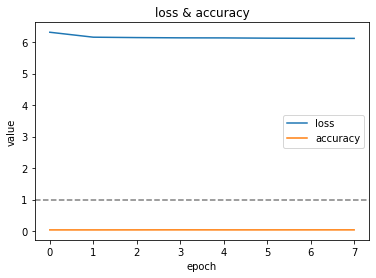

In [22]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.axhline(y=1, color='gray', linestyle='--')
plt.title('loss & accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [25]:
from textblob import TextBlob

In [83]:
dear_maria ='''
I got your picture, I'm coming with you
Dear Maria, count me in
There's a story at the bottom of this bottle
And I'm the pen
When the lights go up
I wanna watch the way you take the stage by storm
The way you wrap those boys around your finger
Go on and play the leader
'Cause you know it's what you're good at
The low road for the fast track, make every second last
'Cause I got your picture, I'm coming with you
Dear Maria, count me in
There's a story at the bottom of this bottle
And I'm the pen
Make it count
When I'm the one who's selling you out
'Cause it feels like stealing hearts
Calling your name from the crowd
Doesn't that mean
You'll be the showgirl of the home team
I'll be the narrator
Telling another tale of the American dream
I see your name in lights
We could make you a star
Girl, we'll take the world by storm
It isn't that hard
'Cause I got your picture, I'm coming with you
Dear Maria, count me in
There's a story at the bottom of this bottle
And I'm the pen
Make it count
When I'm the one who's selling you out
'Cause it feels like stealing hearts
Calling your name from the crowd, whoa
Take a breath, don't it sound so easy?
Never had a doubt, now I'm going crazy
Watching from the floor
Take a breath and let the rest come easy
Never settle down 'cause the cash flow leaves me
Always wanting more
'Cause I got your picture, I'm coming with you
Dear Maria, count me in
There's a story at the bottom of this bottle
And I'm the pen
Make it count
When I'm the one who's selling you out
'Cause it feels like stealing hearts
Calling your name from the crowd
'Cause I got your picture, I'm coming with you
Dear Maria, count me in
There's a story at the bottom of this bottle
'''

In [88]:
all_time_low = TextBlob("there's a place off ocean avenue aim sharpest gracefully clapping flops dose aching hands drives why shining magazine defroster telephone")
all_time_low.sentiment.polarity

0.0

In [84]:
all_time_low_true = TextBlob(dear_maria)
all_time_low_true.sentiment

Sentiment(polarity=0.0933531746031746, subjectivity=0.46795634920634915)

In [68]:
downfall = '''
Let's go
It's not easy making a name for yourself
Where do you draw the line?
I never thought I'd be in this far
Let's have fun some and never change that for anyone
Try not to miss me when I'm gone
I sold my soul to the open road (will be the downfall)
You'll find me in the same spot believe me
I can never stop, my life's turned upside down
Meet me out past the train tracks I'm leavin' and not coming back
You're right and I was wrong
This town will be the downfall of us all
I'm gonna need you to try to follow along
I did the best that I could to try to write you songs
Now go tell them we sold out!
Like we're the ones who changed
I write what I feel, I say what I mean
You can't buy sincerity
I sold my soul to the open road (will be the downfall)
You'll find me in the same spot believe me
I can never stop, my life's turned upside down
Meet me out past the train tracks I'm leavin' and not coming back
You're right and I was wrong
This town will be the downfall of us all
Don't forget yourselves we've made up our minds
We signed three, four, five on the dotted lines
Don't forget yourselves we've made up our minds
And we signed three, four, five on the dotted lines
You'll find me in the same spot believe me
I could never stop, my life's turned upside down
Meet me out past the train tracks I'm leavin' and not coming back
You're right and I was wrong
You'll find me in the same spot believe me
I could never stop, my life's turned upside down
Meet me out past the train tracks I'm leavin' and not coming back
You're right and I was wrong
This town will be the downfall of us all
This town will be the downfall of us all
Downfall of us all
Downfall of us all
Downfall of us all
Downfall of us all'''

In [74]:
adtr_pred = TextBlob(oa + " brightest killjoys waitress shy brown used bills fall motor girl's underdog highways collecting alcohol”")
adtr_pred.sentiment

Sentiment(polarity=-0.5, subjectivity=0.5)

In [75]:
adtr_true = TextBlob(downfall)
adtr_true.sentiment

Sentiment(polarity=-0.05188812083973375, subjectivity=0.4006208397337431)

In [77]:
teen = '''
They're gonna clean up your looks
With all the lies in the books
To make a citizen out of you
Because they sleep with a gun
And keep an eye on you, son
So they can watch all the things you do
Because the drugs never work
They're gonna give you a smirk
'Cause they got methods of keeping you clean
They're gonna rip up your heads
Your aspirations to shreds
Another cog in the murder machine
They said, "All teenagers scare the livin' shit out of me"
They could care less as long as someone'll bleed
So darken your clothes, or strike a violent pose
Maybe they'll leave you alone, but not me
The boys and girls in the clique
The awful names that they stick
You're never gonna fit in much, kid
But if you're troubled and hurt
What you got under your shirt
Will make them pay for the things that they did
They said, "All teenagers scare the livin' shit out of me"
They could care less as long as someone'll bleed
So darken your clothes, or strike a violent pose
Maybe they'll leave you alone, but not me
Oh, yeah!
They said, "All teenagers scare the livin' shit out of me"
They could care less as long as someone'll bleed
So darken your clothes, or strike a violent pose
Maybe they'll leave you alone, but not me
All together now!
"Teenagers scare the livin' shit out of me"
They could care less as long as someone'll bleed
So darken your clothes, or strike a violent pose
Maybe they'll leave you alone, but not me
"Teenagers scare the livin' shit out of me"
They could care less as long as someone'll bleed
So darken your clothes, or strike a violent pose
Maybe they'll leave you alone, but not me'''

In [79]:
mcr_pred = TextBlob(oa + " negative razor inroads disposable satellite others questioned apology dorms teenage planned pour teaching stones")
mcr_pred.sentiment

Sentiment(polarity=-0.15, subjectivity=0.2)

In [78]:
mcr_true = TextBlob(teen)
mcr_true.sentiment

Sentiment(polarity=-0.2557692307692308, subjectivity=0.5897435897435899)

In [80]:
ocean = '''
There's a place of Ocean Avenue
Where I used to sit and talk with you
We were both 16 and it felt so right
Sleepin all day
Stayin up all night
There's a place on the corner of Cherry Street
We would walk on the beach in our bare feet
We were both 18 and it felt so right
Sleepin all day
Stayin up all night
If I could find you now
Things would get better
We could leave this town
And run forever
Let your waves crash down on me
And take me away
There's a piece of you that's here with me
It's everywhere I go
It's everything I see
When I sleep, I dream and it gets me by
I can make believe that you're here tonight
If I could find you now
Things would get better
We could leave this town
And run forever
I know somewhere, somehow we'll be together
Let your waves crash down on me and take me away
I remember the look in your eyes
When you told me that this was goodbye
You were beggin me not tonight
Not here
Not now
We're lookin up at the same night sky
Keep pretending the sun will not rise
We'll be together for one more night
Somewhere
Somehow
If I could find you now
Things would get better
We could leave this town
And run forever
I know somewhere, somehow we'll be together
Let your waves crash down on me
And take me away'''

In [81]:
yc_pred = TextBlob(oa + " unrestful bright snotty unkind sources given ambulances laundry ahold discard lays bags resolve rewind")
yc_pred.sentiment

Sentiment(polarity=0.7000000000000001, subjectivity=0.7999999999999999)

In [82]:
yc_true = TextBlob(ocean)
yc_true.sentiment

Sentiment(polarity=0.1958874458874459, subjectivity=0.37846320346320345)

In [91]:
print(generate_lyrics("she's cheer captain And i'm on the bleachers", 'story so far, the'))

she's cheer captain And i'm on the bleachers god catholic that nonetheless oooooh normal inthe whoa workin wander loose groove
